# Snotel ulmo cuahsi wof
Emilio Mayorga. Run on my conda environment `uwapl_em_mc_1aui`.  
3/7/2017.

In [1]:
%matplotlib inline

from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
# from geojson import Point, Feature, FeatureCollection
# import mplleaflet

import ulmo
from ulmo.util import convert_datetime

/home/mayorga/miniconda/envs/uwapl_em_mc_1aui/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## CUAHSI WaterOneFlow: ulmo, SOAP endpoint, and other general info

In [2]:
print(ulmo.cuahsi.wof.__doc__)


    ulmo.cuahsi.wof
    ~~~~~~~~~~~~~~~

    `CUAHSI WaterOneFlow`_ web services

    .. _CUAHSI WaterOneFlow: http://his.cuahsi.org/wofws.html



In [3]:
print([obj for obj in dir(ulmo.cuahsi.wof) if not obj.startswith('__')])

['absolute_import', 'core', 'get_site_info', 'get_sites', 'get_values', 'get_variable_info']


In [5]:
# WaterML/WOF WSDL endpoints
wsdlurl = "http://worldwater.byu.edu/interactive/snotel/services/index.php/cuahsi_1_1.asmx?WSDL"  # WOF 1.1

# "network code"
# networkcd = "odm2timeseries"

In [6]:
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [10]:
type(sites), len(sites)

(dict, 890)

In [11]:
sites.keys()[:10]

['SNOTEL:323',
 'SNOTEL:1210',
 'SNOTEL:1211',
 'SNOTEL:1212',
 'SNOTEL:1213',
 'SNOTEL:1214',
 'SNOTEL:1215',
 'SNOTEL:1216',
 'SNOTEL:1217',
 'SNOTEL:676']

In [12]:
networkcd = "SNOTEL"

## Get site information

In [13]:
# Site code picked randomly from the list above
sitecd = "323"

In [14]:
siteinfo = ulmo.cuahsi.wof.get_site_info(wsdlurl, networkcd+':'+sitecd)

In [15]:
type(siteinfo), siteinfo.keys()

(dict,
 ['site_property',
  'code',
  'name',
  'series',
  'elevation_m',
  'location',
  'network'])

In [16]:
siteinfo['network'], siteinfo['code'], siteinfo['name']

('SNOTEL', '323', 'Bear Mountain')

In [17]:
# NOTE: 'notes' may not be present in the WaterML 1.1 standard; I'm not sure
# siteinfo['notes']

In [18]:
print(siteinfo['location'])

{'latitude': '48.30577', 'longitude': '-116.07448'}


In [19]:
type(siteinfo['series']), len(siteinfo['series']), siteinfo['series'].keys()

(dict,
 7,
 ['SNOTEL:WTEQ',
  'SNOTEL:TMAX',
  'SNOTEL:PREC',
  'SNOTEL:PRCP',
  'SNOTEL:SNWD',
  'SNOTEL:TAVG',
  'SNOTEL:TMIN'])

In [21]:
siteinfo['series'][networkcd+':'+'SNWD'].keys()

['{http://www.cuahsi.org/water_ml/1.1/}value_count',
 '{http://www.cuahsi.org/water_ml/1.1/}method',
 '{http://www.cuahsi.org/water_ml/1.1/}quality_control_level',
 'variable',
 '{http://www.cuahsi.org/water_ml/1.1/}source',
 '{http://www.cuahsi.org/water_ml/1.1/}variable_time_interval']

In [22]:
siteinfo['series'][networkcd+':'+'SNWD']

{'variable': {'code': 'SNWD',
  'data_type': 'Continuous',
  'general_category': 'Climate',
  'id': '7',
  'name': 'Snow Depth',
  'no_data_value': '-9999',
  'sample_medium': 'Air',
  'speciation': 'Not applicable',
  'time': {'interval': '0',
   'is_regular': True,
   'units': {'abbreviation': 'd',
    'code': '104',
    'name': 'day',
    'type': 'Time'}},
  'units': {'abbreviation': 'cm',
   'code': '47',
   'name': 'centimeter',
   'type': 'Length'},
  'value_type': 'Field Observation',
  'vocabulary': 'SNOTEL'},
 '{http://www.cuahsi.org/water_ml/1.1/}method': {'method_code': '1',
  'method_description': 'No method specified',
  'method_id': '1'},
 '{http://www.cuahsi.org/water_ml/1.1/}quality_control_level': {'definition': 'Quality controlled data',
  'quality_control_level_code': '1',
  'quality_control_level_id': '1'},
 '{http://www.cuahsi.org/water_ml/1.1/}source': {'citation': 'add citation here..',
  'organization': 'USDA NRCS',
  'source_description': 'SNOTEL Data',
  'sour

## Get Values

In [23]:
def site_series_values_to_df(series_values, variable_name):
    # Create a clean timeseries list of (dt,val) tuples
    tsdt_tuplst = [(convert_datetime(valdict['datetime']).replace(tzinfo=pytz.utc), 
                    float(valdict['value']))
                   for valdict in series_values['values']]
    
    dt, val = zip(*tsdt_tuplst)
    ts_df = pd.DataFrame({'time':dt, variable_name:val})
    ts_df.set_index('time', inplace=True)
    ts_df.sort_index(ascending=True, inplace=True)
    return ts_df

In [24]:
print(ulmo.cuahsi.wof.get_values.__doc__)


    Retrieves site values from a WaterOneFlow service using a GetValues request.

    Parameters
    ----------
    wsdl_url : str
        URL of a service's web service definition language (WSDL) description.
        All WaterOneFlow services publish a WSDL description and this url is the
        entry point to the service.
    site_code : str
        Site code of the site you'd like to get values for. Site codes MUST
        contain the network and be of the form <network>:<site_code>, as is
        required by WaterOneFlow.
    variable_code : str
        Variable code of the variable you'd like to get values for. Variable
        codes MUST contain the network and be of the form
        <vocabulary>:<variable_code>, as is required by WaterOneFlow.
    start : ``None`` or datetime (see :ref:`dates-and-times`)
        Start of a date range for a query. If both start and end parameters are
        omitted, the entire time series available will be returned.
    end : ``None`` or datet

In [25]:
# 'odm2timeseries:USU33' is "Oxygen, dissolved percent of saturation"
variablecd = 'SNWD'

site_values = ulmo.cuahsi.wof.get_values(wsdlurl, networkcd+':'+sitecd, networkcd+':'+variablecd)

In [26]:
site_values.keys()

['sources',
 'quality_control_levels',
 'values',
 'censor_codes',
 'variable',
 'site',
 'methods']

In [27]:
sitevariable = site_values['variable']
sitevariable

{'code': 'SNWD',
 'data_type': 'Continuous',
 'general_category': 'Climate',
 'id': '7',
 'name': 'Snow Depth',
 'no_data_value': '-9999',
 'sample_medium': 'Air',
 'speciation': 'Not applicable',
 'time': {'interval': '0',
  'is_regular': True,
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'cm',
  'code': '47',
  'name': 'centimeter   ',
  'type': 'Length'},
 'value_type': 'Field Observation',
 'vocabulary': 'SNOTEL'}

In [28]:
# site_values['values'] is a list of individual time series values (timestamp and data value)
type(site_values['values']), site_values['values'][0].keys()

(list,
 ['method_code',
  'time_offset',
  'value',
  'datetime',
  'date_time_utc',
  'censor_code',
  'source_code',
  'quality_control_level_code'])

In [29]:
# start and end timestamps (local time with time offset vs utc; iso8601 format)
site_values['values'][0]['datetime'], site_values['values'][-1]['datetime']

('1999-09-18T00:00:00', '2017-03-07T00:00:00')

In [30]:
# Set a nice, user-friendly variable name string
variable_name = "%s (%s)" % (sitevariable['name'],  sitevariable['value_type'])
variable_name

'Snow Depth (Field Observation)'

In [31]:
dtstr_last = site_values['values'][-1]['datetime']
convert_datetime(dtstr_last).replace(tzinfo=pytz.utc)

datetime.datetime(2017, 3, 7, 0, 0, tzinfo=<UTC>)

In [32]:
# Hmm, this failed:
# convert_datetime(dtstr_last).astimezone(pytz.utc)
# ValueError: astimezone() cannot be applied to a naive datetime

In [33]:
ts_df = site_series_values_to_df(site_values, variable_name)
ts_df.tail()

,Snow Depth (Field Observation)
time,
2017-03-03 00:00:00+00:00,294.6
2017-03-04 00:00:00+00:00,297.2
2017-03-05 00:00:00+00:00,294.6
2017-03-06 00:00:00+00:00,292.1
2017-03-07 00:00:00+00:00,312.4


In [34]:
type(ts_df), ts_df.columns, ts_df.index.dtype, ts_df.index.min(), ts_df.index.max()

(pandas.core.frame.DataFrame,
 Index([u'Snow Depth (Field Observation)'], dtype='object'),
 datetime64[ns, UTC],
 Timestamp('1999-09-18 00:00:00+0000', tz='UTC'),
 Timestamp('2017-03-07 00:00:00+0000', tz='UTC'))

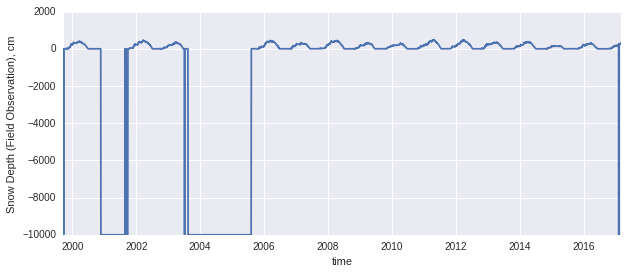

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', ax=ax)
ax.set_ylabel(varlabel + ', ' + sitevariable['units']['abbreviation']);